In [1]:
!pip install facenet-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 81.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 80.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 62.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 888.8 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━

In [2]:
!pip install --upgrade pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 51.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pillow
    Found existing installation: pillow 10.2.0
    Uninstalling pillow-10.2.0:
      Successfully uninstalled pillow-10.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
facenet-pytorch 2.6.0 requires Pillow<10.3.0,>=10.2.0, but you have pillow 11.3.0 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s] 


Training started...


Training complete.
✅ Best Validation Accuracy: 93.60%
✅ Model saved as 'best_gender_model.pth'

📊 Final Training Metrics:
Train Accuracy:  97.56%
Train Precision: 97.56%
Train Recall:    97.56%
Train F1 Score:  97.56%

📊 Final Validation Metrics:
Val Accuracy:  93.60%
Val Precision: 91.43%
Val Recall:    86.81%
Val F1 Score:  88.88%

📊 Classification Report (Validation Set):

              precision    recall  f1-score   support

      female       0.88      0.76      0.82        79
        male       0.95      0.98      0.96       343

    accuracy                           0.94       422
   macro avg       0.91      0.87      0.89       422
weighted avg       0.93      0.94      0.93       422



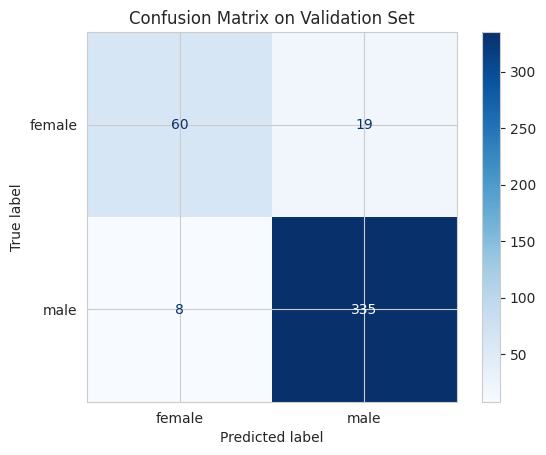


📊 Classification Report (Test Set):

              precision    recall  f1-score   support

      female     0.8768    0.9868    0.9286       303
        male     0.9975    0.9741    0.9857      1623

    accuracy                         0.9761      1926
   macro avg     0.9372    0.9805    0.9571      1926
weighted avg     0.9785    0.9761    0.9767      1926



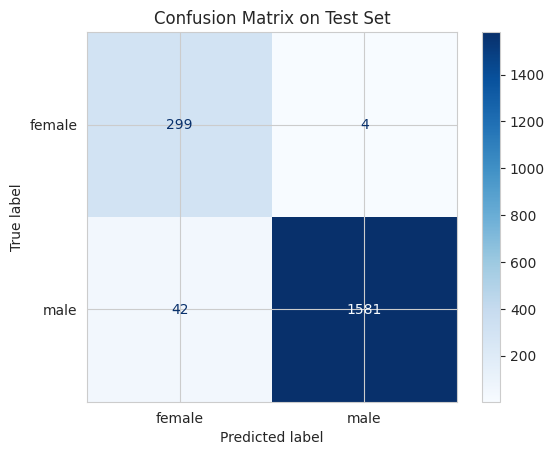

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from PIL import Image
import numpy as np
import copy
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ---------------------- SETUP ----------------------
num_classes = 2
batch_size = 16
num_epochs = 10
learning_rate = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------------- TRANSFORMS ----------------------
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ---------------------- MODEL DEFINITION ----------------------
def get_model():
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.fc = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(model.fc.in_features, num_classes)
    )
    return model.to(device)

# ---------------------- TRAINING FUNCTION ----------------------
def train_model(train_dir, val_dir):
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
    val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transform)
    class_names = train_dataset.classes

    # Handle class imbalance
    targets = [label for _, label in train_dataset.samples]
    class_counts = np.bincount(targets)
    class_weights = 1. / class_counts
    sample_weights = [class_weights[label] for label in targets]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    model = get_model()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    print("Training started...\n")
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_correct = 0
        with torch.no_grad():
            for image, label in val_loader:
                image, label = image.to(device), label.to(device)
                output = model(image)
                pred = torch.argmax(output, dim=1)
                if pred.item() == label.item():
                    val_correct += 1

        val_acc = val_correct / len(val_dataset)
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print("\nTraining complete.")

    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), "best_gender_model.pth")
    print(f"✅ Best Validation Accuracy: {best_acc * 100:.2f}%")
    print("✅ Model saved as 'best_gender_model.pth'")

    # -------------------- Final Train Metrics --------------------
    model.eval()
    all_train_preds, all_train_labels = [], []
    with torch.no_grad():
        for images, labels in train_loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(1).cpu().numpy()
            all_train_preds.extend(preds)
            all_train_labels.extend(labels.numpy())

    train_acc = accuracy_score(all_train_labels, all_train_preds)
    train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')
    train_precision = precision_score(all_train_labels, all_train_preds, average='macro')
    train_recall = recall_score(all_train_labels, all_train_preds, average='macro')

    print("\n📊 Final Training Metrics:")
    print(f"Train Accuracy:  {train_acc * 100:.2f}%")
    print(f"Train Precision: {train_precision * 100:.2f}%")
    print(f"Train Recall:    {train_recall * 100:.2f}%")
    print(f"Train F1 Score:  {train_f1 * 100:.2f}%")

    # -------------------- Final Validation Report --------------------
    all_preds, all_labels = [], []
    with torch.no_grad():
        for image, label in val_loader:
            image = image.to(device)
            output = model(image)
            pred = torch.argmax(output, dim=1)
            all_preds.append(pred.item())
            all_labels.append(label.item())
    val_acc = accuracy_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds, average='macro')
    val_precision = precision_score(all_labels, all_preds, average='macro')
    val_recall = recall_score(all_labels, all_preds, average='macro')
    
    print("\n📊 Final Validation Metrics:")
    print(f"Val Accuracy:  {val_acc * 100:.2f}%")
    print(f"Val Precision: {val_precision * 100:.2f}%")
    print(f"Val Recall:    {val_recall * 100:.2f}%")
    print(f"Val F1 Score:  {val_f1 * 100:.2f}%")
    
    print("\n📊 Classification Report (Validation Set):\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix on Validation Set")
    plt.show()

    return class_names

# ---------------------- TEST FUNCTION ----------------------
def test_model(test_dir, class_names):
    test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    model = get_model()
    model.load_state_dict(torch.load("best_gender_model.pth", map_location=device))
    model.eval()

    all_preds = []
    all_labels = []
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(device)
            output = model(image)
            pred = torch.argmax(output, dim=1).cpu().item()
            all_preds.append(pred)
            all_labels.append(label.item())

    print("\n📊 Classification Report (Test Set):\n")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix on Test Set")
    plt.show()

# ---------------------- MAIN ENTRY ----------------------
if __name__ == "__main__":
    set_seed(42)
    train_dir = "/kaggle/input/comsys-dataset/Comys_Hackathon5/Task_A/train"
    val_dir = "/kaggle/input/comsys-dataset/Comys_Hackathon5/Task_A/val"
    test_dir = "/kaggle/input/comsys-dataset/Comys_Hackathon5/Task_A/train"  # You can change if test set is separate

    class_names = train_model(train_dir, val_dir)
    test_model(test_dir, class_names)